# Beard Removal Dataset Generation Demo
This notebook demonstrates how to use the StableDiffusionGenerator to create paired images (with and without beard) and generate a full dataset.

In [ ]:
# Clone the project repository if running in Colab (uncomment if needed)
#!git clone https://github.com/ErayOnder/AI-BeardRemoval-Project.git
#%cd AI-BeardRemoval-Project
#%pip install -r requirements.txt

## Configuration

In [5]:
# Python Standard Libraries
import sys
import os
import random
import argparse # For creating argument Namespace
from pathlib import Path

# Third-party Libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader # DataLoader is used in train.py, but good to have if needed directly
import torchvision.transforms as T # For metrics cell if transforming PIL images
from tqdm import tqdm # tqdm is used in train.py

# Check if running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Configure environment based on runtime
if is_colab():
    print("Running in Google Colab environment")
    from google.colab import drive
    drive.mount('/content/drive')
    # Set output directory in Google Drive
    output_dir = '/content/drive/MyDrive/beard_dataset'
    pix2pix_checkpoint_dir = '/content/drive/MyDrive/beard_removal_models'
else:
    print("Running in local environment")
    # Set output directory locally
    output_dir = 'dataset'
    pix2pix_checkpoint_dir = 'models'

# --- Project-specific imports ---
# Ensure the project root is in the Python path
# This assumes your notebook is in the 'AI-BeardRemoval-Project' root after %cd
if "." not in sys.path:
    sys.path.append(".")

from utils.stable_diffusion_helper import StableDiffusionGenerator
from training.train import train
from training.plot_metrics import plot_training_metrics, load_metrics_from_checkpoint
from testing.metrics import compute_ssim, compute_psnr
from testing.inference import predict

print("All modules imported successfully.")

# --- Configuration ---
# Create directories
os.makedirs(output_dir, exist_ok=True)
os.makedirs(pix2pix_checkpoint_dir, exist_ok=True)

print(f"Dataset directory: {output_dir}")
print(f"Model checkpoints will be saved in: {pix2pix_checkpoint_dir}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Running in local environment
All modules imported successfully.
Dataset directory: dataset
Model checkpoints will be saved in: models
Using device: mps


## Dataset Generation

In [ ]:
# Initialize the Stable Diffusion generator
# This might take some time to download models if run for the first time
print("Initializing StableDiffusionGenerator...")
sd_generator = StableDiffusionGenerator()
print("StableDiffusionGenerator initialized.")

# Generate the dataset
num_dataset_pairs = 100  # Number of image pairs for the dataset
test_set_split = 0.2    # 20% for the test set

print(f"Generating dataset with {num_dataset_pairs} pairs to {output_dir}...")
sd_generator.generate_dataset(
    num_pairs=num_dataset_pairs,
    test_split=test_set_split,
    output_dir=output_dir,
    use_face_detection=True # Set to False if face_recognition causes issues or for faster generation
)
print("Dataset generation complete.")

# Verify dataset structure (optional)
train_beard_count = len(list(Path(output_dir, "train", "beard").glob("*.png")))
train_nobeard_count = len(list(Path(output_dir, "train", "no_beard").glob("*.png")))
test_beard_count = len(list(Path(output_dir, "test", "beard").glob("*.png")))
test_nobeard_count = len(list(Path(output_dir, "test", "no_beard").glob("*.png")))

print(f"Train beard images: {train_beard_count}")
print(f"Train no_beard images: {train_nobeard_count}")
print(f"Test beard images: {test_beard_count}")
print(f"Test no_beard images: {test_nobeard_count}")

if train_beard_count == 0 or test_beard_count == 0:
    print("Warning: Dataset seems empty. Check the generation process and paths.")

#### Generate 10 Sample Paired Images

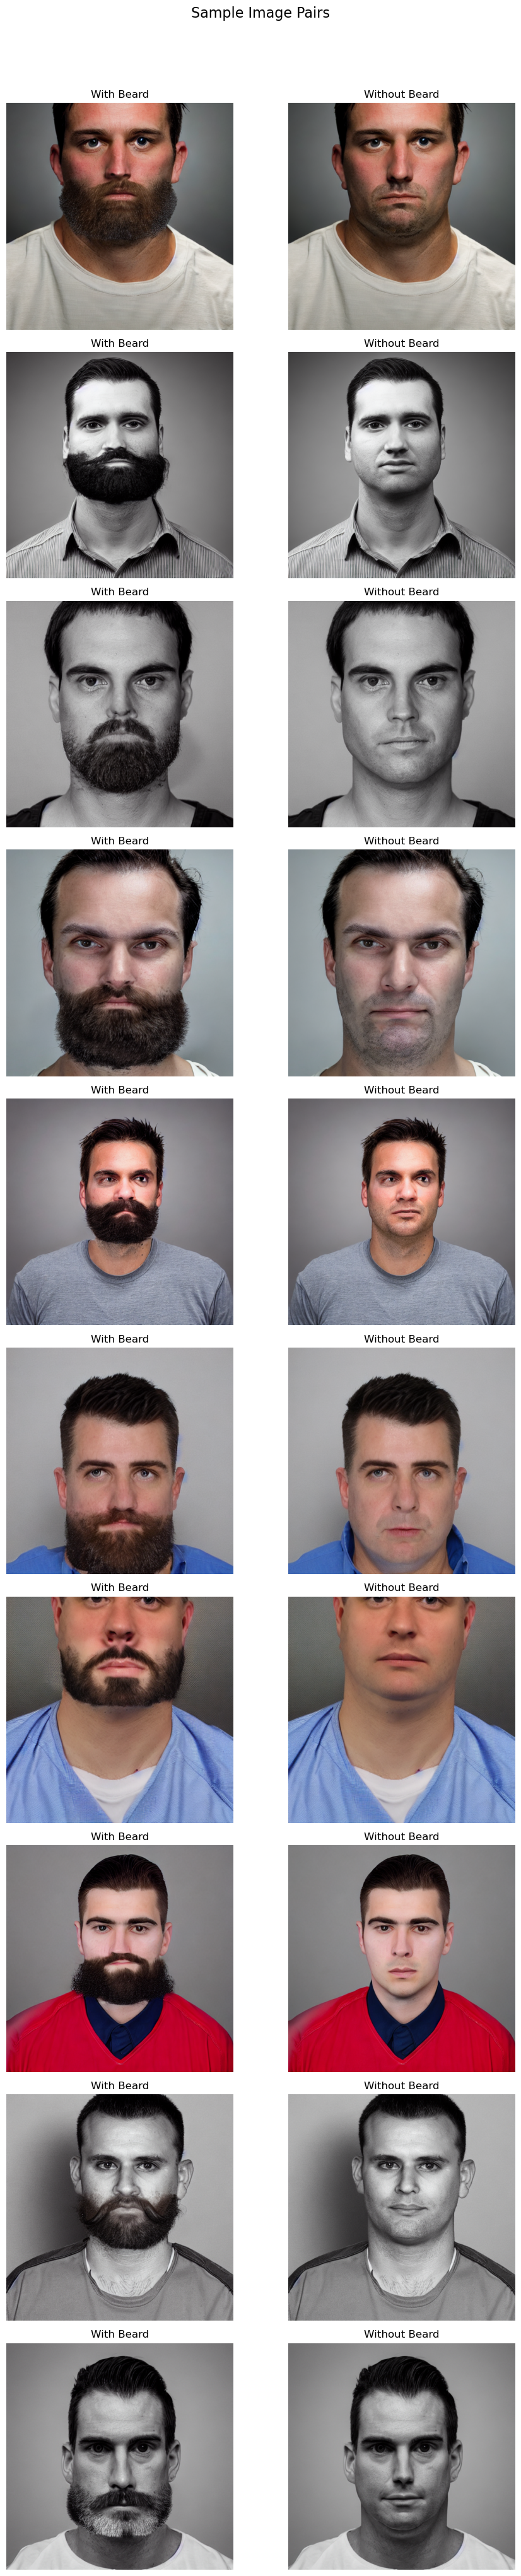

In [11]:
# List all available pairs in train/beard
beard_dir = os.path.join(output_dir, "train", "beard")
no_beard_dir = os.path.join(output_dir, "train", "no_beard")

beard_files = [f for f in os.listdir(beard_dir) if f.endswith('_beard.png')]

# Randomly select 10 pairs
sample_files = random.sample(beard_files, min(10, len(beard_files)))

# Create a figure with subplots for all pairs
num_pairs = len(sample_files)
fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 4*num_pairs))
fig.suptitle('Sample Image Pairs', fontsize=16, y=1.02)

for idx, f in enumerate(sample_files):
    beard_path = os.path.join(beard_dir, f)
    nobeard_path = os.path.join(no_beard_dir, f.replace('_beard.png', '_nobeard.png'))
    
    if os.path.exists(beard_path) and os.path.exists(nobeard_path):
        # Load and display beard image
        beard_img = Image.open(beard_path)
        axes[idx, 0].imshow(beard_img)
        axes[idx, 0].axis('off')
        axes[idx, 0].set_title('With Beard')
        
        # Load and display no-beard image
        nobeard_img = Image.open(nobeard_path)
        axes[idx, 1].imshow(nobeard_img)
        axes[idx, 1].axis('off')
        axes[idx, 1].set_title('Without Beard')

plt.tight_layout()
plt.show()

## Model Training

In [3]:
# --- Training Configuration for Pix2Pix ---
# Create an Namespace object to hold training arguments
train_args = argparse.Namespace(
    epochs=50, 
    batch_size=1, 
    lr=0.0002,
    lambda_l1=100.0,
    data_dir=output_dir, # Directory where the 'train' and 'test' splits are located
    checkpoint_dir=pix2pix_checkpoint_dir, # Directory to save model checkpoints
    device=device
)

print("Starting Pix2Pix model training...")
print(f"Training arguments: {train_args}")

# Call the train function
# The train.py script handles model initialization, dataloaders, optimizer, and the training loop.
try:
    metrics, generator = train(train_args)
    print("Training finished.")
except Exception as e:
    print(f"An error occurred during training: {e}")
    import traceback
    traceback.print_exc()

INFO:training.dataset:Found 80 image pairs in train set
INFO:training.dataset:Found 20 image pairs in test set


Starting Pix2Pix model training...
Training arguments: Namespace(epochs=50, batch_size=1, lr=0.0002, lambda_l1=100.0, data_dir='dataset', checkpoint_dir='models', device=device(type='mps'))
Using device: mps


Epoch 1/50: 100%|██████████| 80/80 [00:55<00:00,  1.45it/s, D_loss=0.689, G_loss=15.2, G_GAN=0.808, G_L1=14.4]



Validation - SSIM: 0.7242, PSNR: 21.9697


Epoch 2/50: 100%|██████████| 80/80 [00:34<00:00,  2.31it/s, D_loss=0.666, G_loss=11.4, G_GAN=0.855, G_L1=10.5]



Validation - SSIM: 0.7820, PSNR: 22.7426


Epoch 3/50: 100%|██████████| 80/80 [00:36<00:00,  2.20it/s, D_loss=0.665, G_loss=10.2, G_GAN=0.85, G_L1=9.34] 



Validation - SSIM: 0.7637, PSNR: 21.1703


Epoch 4/50: 100%|██████████| 80/80 [00:36<00:00,  2.21it/s, D_loss=0.651, G_loss=9.65, G_GAN=0.902, G_L1=8.75]



Validation - SSIM: 0.7640, PSNR: 19.3383


Epoch 5/50: 100%|██████████| 80/80 [00:35<00:00,  2.28it/s, D_loss=0.632, G_loss=9.29, G_GAN=0.944, G_L1=8.35]



Validation - SSIM: 0.7979, PSNR: 21.0704


Epoch 6/50: 100%|██████████| 80/80 [00:36<00:00,  2.21it/s, D_loss=0.593, G_loss=9.3, G_GAN=1.16, G_L1=8.14]  



Validation - SSIM: 0.8201, PSNR: 23.2083


Epoch 7/50: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s, D_loss=0.597, G_loss=8.87, G_GAN=1.06, G_L1=7.81] 



Validation - SSIM: 0.8022, PSNR: 21.3591


Epoch 8/50: 100%|██████████| 80/80 [00:36<00:00,  2.18it/s, D_loss=0.62, G_loss=8.61, G_GAN=1.01, G_L1=7.6]  



Validation - SSIM: 0.8142, PSNR: 22.2381


Epoch 9/50: 100%|██████████| 80/80 [00:36<00:00,  2.19it/s, D_loss=0.616, G_loss=8.5, G_GAN=0.992, G_L1=7.51] 



Validation - SSIM: 0.8266, PSNR: 23.5448


Epoch 10/50: 100%|██████████| 80/80 [00:36<00:00,  2.22it/s, D_loss=0.631, G_loss=8.3, G_GAN=1, G_L1=7.3]      



Validation - SSIM: 0.8243, PSNR: 22.8844


Epoch 11/50: 100%|██████████| 80/80 [00:40<00:00,  1.99it/s, D_loss=0.621, G_loss=8.08, G_GAN=1, G_L1=7.08]    



Validation - SSIM: 0.8392, PSNR: 24.1786


Epoch 12/50: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, D_loss=0.621, G_loss=7.85, G_GAN=1.01, G_L1=6.84] 



Validation - SSIM: 0.8422, PSNR: 24.5251


Epoch 13/50: 100%|██████████| 80/80 [00:40<00:00,  1.98it/s, D_loss=0.638, G_loss=7.62, G_GAN=0.982, G_L1=6.64]



Validation - SSIM: 0.8328, PSNR: 23.7056


Epoch 14/50: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, D_loss=0.617, G_loss=7.46, G_GAN=0.985, G_L1=6.48]



Validation - SSIM: 0.8489, PSNR: 24.4272


Epoch 15/50: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, D_loss=0.619, G_loss=7.29, G_GAN=0.969, G_L1=6.32]



Validation - SSIM: 0.8422, PSNR: 24.1422


Epoch 16/50: 100%|██████████| 80/80 [00:40<00:00,  2.00it/s, D_loss=0.623, G_loss=7.32, G_GAN=0.992, G_L1=6.33]



Validation - SSIM: 0.8543, PSNR: 23.7952


Epoch 17/50: 100%|██████████| 80/80 [00:39<00:00,  2.03it/s, D_loss=0.634, G_loss=7.06, G_GAN=0.968, G_L1=6.09]



Validation - SSIM: 0.8517, PSNR: 23.8584


Epoch 18/50: 100%|██████████| 80/80 [00:40<00:00,  2.00it/s, D_loss=0.633, G_loss=7.01, G_GAN=0.966, G_L1=6.04]



Validation - SSIM: 0.8486, PSNR: 24.1874


Epoch 19/50: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s, D_loss=0.619, G_loss=6.89, G_GAN=0.976, G_L1=5.92]



Validation - SSIM: 0.8464, PSNR: 24.0951


Epoch 20/50: 100%|██████████| 80/80 [00:42<00:00,  1.88it/s, D_loss=0.645, G_loss=6.8, G_GAN=0.975, G_L1=5.82] 



Validation - SSIM: 0.8468, PSNR: 22.6788
Saved checkpoint: models/generator_epoch_020.pth


Epoch 21/50: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s, D_loss=0.629, G_loss=6.6, G_GAN=0.952, G_L1=5.65] 



Validation - SSIM: 0.8504, PSNR: 24.4405


Epoch 22/50:  75%|███████▌  | 60/80 [00:30<00:10,  1.95it/s, D_loss=0.633, G_loss=6.64, G_GAN=0.977, G_L1=5.67]


KeyboardInterrupt: 

#### Plot the metrics

In [12]:
# Plot the metrics from the training
if metrics:
    plot_training_metrics(metrics)

# Load the metrics from the best generator checkpoint
checkpoint_path = Path(pix2pix_checkpoint_dir) / "best_generator.pth"
if checkpoint_path:
    loaded_metrics = load_metrics_from_checkpoint(checkpoint_path, device=device)
    if loaded_metrics:
        plot_training_metrics(loaded_metrics)

NameError: name 'metrics' is not defined

# Inference

In [13]:
print("Running inference with the trained model...")

# --- Inference Configuration ---
num_samples = 4  # Number of sample images to process
# Path to a sample input image from the test set
test_beard_dir = Path(output_dir) / "test" / "beard"
sample_image_files = list(test_beard_dir.glob("*_beard.png"))
if not sample_image_files:
    print(f"No images found in {test_beard_dir}. Cannot run inference.")
else:
    num_samples = min(num_samples, len(sample_image_files))
    sample_image_paths = random.sample(sample_image_files, num_samples)
    print(f"Selected {num_samples} random test images")

# Path to the trained model checkpoint
trained_model_path = Path(pix2pix_checkpoint_dir) / "best_generator.pth"
if not trained_model_path:
    print("No trained model found. Please train the model first.")
print(f"Using model checkpoint: {trained_model_path}")


if sample_image_paths and trained_model_path.exists():
    try:
        fig = plt.figure(figsize=(15, 5 * num_samples))
        fig.suptitle("Beard Removal Inference Results", fontsize=16, y=1.02)

        metrics = []

        for idx, sample_path in enumerate(sample_image_paths):
            # Perform prediction using the predict function from testing.inference
            predicted_pil_image = predict(img_path=sample_path, model_path=trained_model_path, device=device)

            # Display the original and ground truth images
            original_pil_image = Image.open(sample_path).convert("RGB")
            ground_truth_path = sample_path.replace("/beard/", "/no_beard/").replace("_beard.png", "_nobeard.png")
            ground_truth_pil_image = Image.open(ground_truth_path).convert("RGB")

            # Create subplot for this sample
            axes = []
            for j in range(3):
                ax = plt.subplot(num_samples, 3, idx * 3 + j + 1)
                axes.append(ax)

            # Display images
            axes[0].imshow(original_pil_image)
            axes[0].set_title("Original (With Beard)")
            axes[0].axis("off")

            axes[1].imshow(ground_truth_pil_image)
            axes[1].set_title("Ground Truth (No Beard)")
            axes[1].axis("off")

            axes[2].imshow(predicted_pil_image)
            axes[2].set_title("Predicted (No Beard)")
            axes[2].axis("off")
            
            # Calculate metrics
            ssim_value = compute_ssim(ground_truth_pil_image, predicted_pil_image)
            psnr_value = compute_psnr(ground_truth_pil_image, predicted_pil_image)
            metrics.append((ssim_value, psnr_value))

            # Add metrics as text under the predicted image
            axes[2].text(0.5, -0.1, f"SSIM: {ssim_value:.4f}\nPSNR: {psnr_value:.2f}",
                         horizontalalignment="center",
                         transform=axes[2].transAxes)
        
        plt.tight_layout()
        plt.show()

        # Print average metrics
        if metrics:
            avg_ssim = sum(m[0] for m in metrics) / len(metrics)
            avg_psnr = sum(m[1] for m in metrics) / len(metrics)
            print(f"\nAverage metrics across {num_samples} samples:")
            print(f"Average SSIM: {avg_ssim:.4f}")
            print(f"Average PSNR: {avg_psnr:.2f}")

    except Exception as e:
        print(f"An error occurred during inference: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping inference due to missing sample image or model checkpoint.")

Running inference with the trained model...
Selected 4 random test images
Using model checkpoint: models/best_generator.pth
An error occurred during inference: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this 

Traceback (most recent call last):
  File "/var/folders/2c/pdmvtd290llgjlrnrrkf89x40000gn/T/ipykernel_79461/240153178.py", line 31, in <module>
    predicted_pil_image = predict(img_path=sample_path, model_path=trained_model_path, device=device)
  File "/Users/erayonder/Desktop/AI-BeardRemoval Project/testing/inference.py", line 80, in predict
  File "/Users/erayonder/Desktop/AI-BeardRemoval Project/testing/inference.py", line 22, in load_model
    model.load_state_dict(checkpoint['model_state_dict'])
                 ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml_ai/lib/python3.13/site-packages/torch/serialization.py", line 1470, in load
    raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in

<Figure size 1500x2000 with 0 Axes>